In this example the neural network that recognizes hand-written digit (provided by MNIST) is built and used to predict the results on the test set. ADAM optimizer and minibatch gradient descent was used to train model with 10000 images. Test set with 1000 images was tested and accuracy is 87.5%. Model takes 28x28 pixel image and outputs digit (0 - 9) shown on it

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']
  test_examples = data['x_test']
  test_labels = data['y_test']

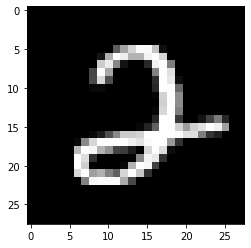

In [2]:
plt.gray()

X = train_examples[16]
plt.imshow(X)

In [3]:
m = len(train_examples)
m

60000

In [4]:
len(test_examples)

10000

In [5]:
train_set = train_examples[0: 10000]
train_set_labels = train_labels[0: 10000]
test_set = test_examples[0: 1000]
test_set_labels = test_labels[0 : 1000]

1


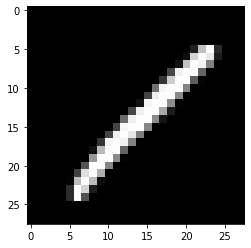

In [6]:
plt.gray()

X = train_set[533]
plt.imshow(X)
print(train_set_labels[533])

In [7]:
print(len(train_set), len(train_set_labels))
print(len(test_set), len(test_set_labels))
print(train_set.shape, train_set_labels.shape)

10000 10000
1000 1000
(10000, 28, 28) (10000,)


In [8]:
train_set[533].reshape(28*28, )

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  33, 193, 254,  42,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [9]:
Y_train = np.reshape(train_set_labels, (1, 10000))
Y_test = np.reshape(test_set_labels, (1, 1000))
X_train = np.zeros((28*28, 10000))
X_test = np.zeros((28*28, 1000))
for i in range(len(train_set)):
    X_train[:, i] = np.reshape(train_set[i], (28 * 28))

for i in range(len(test_set)):
    X_test[:, i] = np.reshape(test_set[i], (28 * 28))
    
assert(X_train.shape == (28*28, 10000))
assert(X_test.shape == (28 * 28, 1000))
assert(Y_train.shape == (1, 10000))
assert(Y_test.shape == (1, 1000))

1


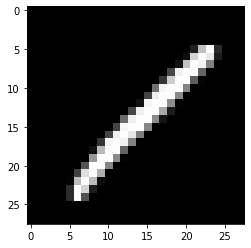

In [10]:
X = np.reshape(X_train[:, 533], (28, 28))
plt.gray()

plt.imshow(X)
print(Y_train[0, 533])

In [11]:
print(Y_train.shape)

(1, 10000)


In [12]:
print(X_train.shape)

(784, 10000)


In [13]:
Y_test.shape

(1, 1000)

In [14]:
train_Y = np.zeros((10, 10000))
for i in range(10000):
    j = int(Y_train[:, i])
    train_Y[j, i] = 1

    
test_Y = np.zeros((10, 1000))
for i in range(1000):
    j = int(Y_test[:, i]) 
    test_Y[j, i] = 1

In [15]:
Y_train = train_Y
Y_test = test_Y

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


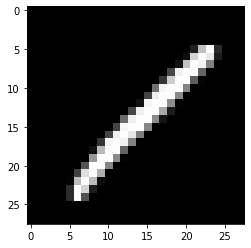

In [16]:
X = np.reshape(X_train[:, 533], (28, 28))
plt.gray()

plt.imshow(X)
print(Y_train[:, 533])

In [17]:
print(Y_train.shape)

(10, 10000)


# Shuffling Data to minibatches

In [18]:
def random_minibatches(X, Y, minibatch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[0]
    permutations = list(np.random.permutation(m))
    shuffled_X = X[:, permutations]
    shuffled_Y = Y[:, permutations]
    num_complete_minibatches = m // minibatch_size
    last_minibatch_size = m - num_complete_minibatches * minibatch_size
    
    minibatches = []
    for i in range(num_complete_minibatches):
        minibatches_X = shuffled_X[:, i * minibatch_size: (i + 1) * minibatch_size]
        minibatches_Y = shuffled_Y[:, i * minibatch_size: (i + 1) * minibatch_size]
        minibatch = (minibatches_X, minibatches_Y)
        minibatches.append(minibatch)
    
    last_minibatch_X = shuffled_X[:, num_complete_minibatches * minibatch_size: m]
    last_minibatch_Y = shuffled_Y[:, num_complete_minibatches * minibatch_size: m]
    last_minibatch = (last_minibatch_X, last_minibatch_Y)
    minibatches.append(last_minibatch)
    return minibatches

# Generating Forward Prop

In [19]:
def relu(z):
    return np.maximum(0, z)

In [20]:
def relu_backward(z):
    return 1 * (z > 0)

In [21]:
def sigmoid(z):
    t = np.exp(z)
    result = t/np.sum(t, axis = 0, keepdims = True)
    return result

In [22]:
def sigmoid_backward(a):
    return a*(1 - a)

In [23]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    L = len(layer_dims)
    parameters = {}
    for i in range(1, L):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * 0.01
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
    return parameters

In [24]:
def forward_prop(parameters, X):
    L = len(layer_dims)
    cache = {}
    cache["A0"] = X
    for i in range(1, L - 1):
        cache["Z" + str(i)] = np.dot(parameters["W" + str(i)], cache["A" + str(i - 1)]) + parameters["b" + str(i)]
        cache["A" + str(i)] = relu(cache["Z" + str(i)])
    
    cache["Z" + str(L - 1)] = np.dot(parameters["W" + str(L - 1)], cache["A" + str(L - 2)]) + parameters["b" + str(L - 1)]
    cache["A" + str(L - 1)] = sigmoid(cache["Z" + str(L - 1)])
    
    return cache

## Check       

In [25]:
layer_dims = [784, 3136, 448, 64, 10]
params = initialize_parameters(layer_dims)
Cache = forward_prop(params, X_train)

In [26]:
params["b2"].shape

(448, 1)

In [27]:
Cache["A1"].shape

(3136, 10000)

In [28]:
Y_train.shape

(10, 10000)

In [29]:
Cache["A4"][:, 27]

array([0.09720779, 0.10021043, 0.09742983, 0.10962139, 0.10863931,
       0.09643287, 0.10356552, 0.09104502, 0.09763357, 0.09821426])

In [30]:
print(Cache["A1"][:, 27].shape)

(3136,)


In [31]:
print(Y_train[:, 27].shape)

(10,)


In [32]:
mini = random_minibatches(X_train, Y_train)

In [33]:
A = mini[3][0][:][:, 27].reshape(28, 28)

In [34]:
print(mini[3][1].shape)

(10, 64)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


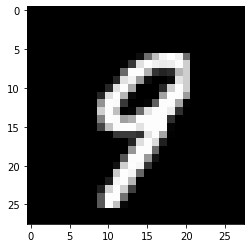

In [35]:

plt.gray()

plt.imshow(A)
print(mini[3][1][:, 27])

# Compute Cost

In [67]:
def compute_cost(cache, Y):
    L = len(cache) // 2
    AL = cache["A" + str(L)]
    m = Y.shape[0]
    assert(AL.shape == Y.shape)
    cost = -np.sum(Y * np.log(AL), axis = 0, keepdims = True)
    costs = 1/m * np.sum(cost, axis = 1, keepdims = True)
    return costs

In [37]:
compute_cost(Cache, Y_train)

array([[2305.7647195]])

In [38]:
Y_train.shape

(10, 10000)

In [39]:
Cache["A4"].shape

(10, 10000)

In [40]:
def backward_prop(parameters, cache, Y):
    m = Y.shape[1]
    grads = {}
    L = len(cache) // 2
    AL = cache["A" + str(L)]
    for i in range(L, 0, -1):
        if i == L:
            grads["dZ" + str(L)] = AL - Y
        else:
            grads["dZ" + str(i)] = grads["dA" + str(i)] * relu_backward(cache["Z" + str(i)])
        
        grads["dW" + str(i)] = 1/m  * np.dot(grads["dZ" + str(i)], cache["A" + str(i - 1)].T)
        grads["db" + str(i)] = 1/m * np.sum(grads["dZ" + str(i)], axis = 1, keepdims = True)
        grads["dA" + str(i - 1)] = np.dot(parameters["W" + str(i)].T, grads["dZ" + str(i)])
        
        
    return grads

In [41]:
grd = backward_prop(params, Cache, Y_train)

In [42]:
grd

{'dZ4': array([[ 0.09830272, -0.90756727,  0.10568418, ...,  0.09961376,
          0.10365534,  0.0974518 ],
        [ 0.09990186,  0.09358919,  0.10236225, ...,  0.10153604,
          0.09533263,  0.10022751],
        [ 0.09614888,  0.10422332,  0.09212616, ...,  0.10436322,
          0.09427341,  0.09656147],
        ...,
        [ 0.09358885,  0.09297443,  0.09427171, ...,  0.09510933,
          0.0930325 , -0.90944041],
        [ 0.10356242,  0.09649728,  0.10211784, ...,  0.09621549,
          0.10646996,  0.10442614],
        [ 0.09427108,  0.09517648,  0.09679478, ...,  0.09257397,
         -0.89876572,  0.09633245]]),
 'dW4': array([[-9.92637424e-03,  6.51629556e-03,  7.74197951e-03,
         -1.87252091e-02, -7.52201943e-02,  1.21276136e-03,
         -5.43085784e-03, -2.62375170e-02, -3.09461545e-03,
          4.07775135e-02,  1.41778400e-02, -2.30240041e-02,
          1.12121543e-02, -4.79299712e-02,  1.84744655e-02,
         -2.44754897e-02, -5.72507246e-02,  6.98367860e-03,

In [43]:
def initialize(parameters):
    v = {}
    s = {}
    L = len(parameters) // 2
    for i in range(1, L + 1):
        v["dW" + str(i)] = np.zeros((parameters["W" + str(i)].shape[0], parameters["W" + str(i)].shape[1]))
        v["db" + str(i)] = np.zeros((parameters["b" + str(i)].shape[0], parameters["b" + str(i)].shape[1]))
        s["dW" + str(i)] = np.zeros((parameters["W" + str(i)].shape[0], parameters["W" + str(i)].shape[1]))
        s["db" + str(i)] = np.zeros((parameters["b" + str(i)].shape[0], parameters["b" + str(i)].shape[1]))
    return v, s

In [44]:
grd["dA1"].shape

(3136, 10000)

In [45]:
def update_parameters(parameters, grads, v, s, t, learning_rate = 0.01, 
                      beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {} 
    for i in range(1, L + 1):
        v["dW" + str(i)] = beta1 * v["dW" + str(i)] + (1 - beta1) * grads["dW" + str(i)]
        v["db" + str(i)] = beta1 * v["db" + str(i)] + (1 - beta1) * grads["db" + str(i)]
        v_corrected["dW" + str(i)] =  v["dW" + str(i)] / (1 - beta1**t)
        v_corrected["db" + str(i)] =  v["db" + str(i)] / (1 - beta1**t)
        s["dW" + str(i)] = beta2 * s["dW" + str(i)] + (1 - beta2) * grads["dW" + str(i)]**2
        s["db" + str(i)] = beta2 * s["db" + str(i)] + (1 - beta2) * grads["db" + str(i)]**2
        s_corrected["dW" + str(i)] =  s["dW" + str(i)] / (1 - beta2**t)
        s_corrected["db" + str(i)] =  s["db" + str(i)] / (1 - beta2**t)
        
        parameters["W" + str(i)] -= learning_rate * v_corrected["dW" + str(i)] / (np.sqrt(s_corrected["dW" + str(i)]) + epsilon)
        parameters["b" + str(i)] -= learning_rate * v_corrected["db" + str(i)] / (np.sqrt(s_corrected["db" + str(i)]) + epsilon)
    
    return parameters, v, s, v_corrected, s_corrected
        

In [98]:
def model(X, Y, layers_dims, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 100, print_cost = True):
    L = len(layer_dims)
    parameters = initialize_parameters(layer_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    v, s = initialize(parameters)
    
    for i in range(num_epochs):
        seed += 1
        minibatches = random_minibatches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            cache = forward_prop(parameters, minibatch_X)
            cost_total += compute_cost(cache, minibatch_Y)
            grads = backward_prop(parameters, cache, minibatch_Y)
            t += 1
            parameters, v, s, _, _ = update_parameters(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
            cost_avg = cost_total/m
        
        if print_cost and i % 10 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost:
            costs.append(cost_avg[0][0])
    
    x = list(range(num_epochs))
    plt.plot(x, costs)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Cost")
    plt.title("Learning rate " + str(learning_rate))
    plt.show()
    
    return parameters, costs

Cost after epoch 0: 0.010796
Cost after epoch 10: 0.000011
Cost after epoch 20: 0.000001
Cost after epoch 30: 0.000001
Cost after epoch 40: 0.000000
Cost after epoch 50: 0.000000
Cost after epoch 60: 0.000000
Cost after epoch 70: 0.000000
Cost after epoch 80: 0.000000
Cost after epoch 90: 0.000000


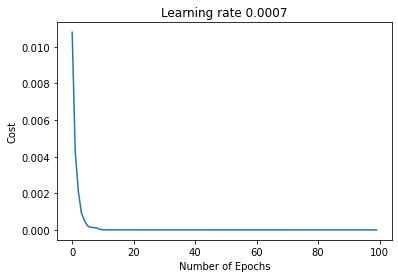

In [99]:
layers_dims = [784, 3136, 448, 64, 10]
parameters, costs = model(X_train, Y_train, layers_dims)

In [100]:
forward_prop(parameters, X_test)["A4"][:, 666]

array([2.02967734e-14, 5.84612253e-15, 2.22386940e-12, 1.44780226e-11,
       1.25958852e-13, 5.39649670e-15, 1.46562002e-20, 9.99995446e-01,
       5.23387645e-15, 4.55418507e-06])

In [101]:
Y_test[:, 666]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


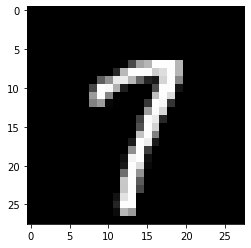

In [102]:
X = np.reshape(X_test[:, 666], (28, 28))
plt.gray()

plt.imshow(X)
print(Y_test[:, 666])

In [103]:
def predict(parameters, dataset_X, dataset_Y):
    L = len(parameters) // 2
    res = forward_prop(parameters, dataset_X)
    result = res["A" + str(L)]/np.sum(res["A" + str(L)], axis = 0)
    answer = []
    for i in range(dataset_X.shape[1]):
        maximum = max(list(result[:, i]))
        index = list(result[:, i]).index(maximum)
        answer.append(index)

    cost = 1 /(dataset_Y.shape[1]) * compute_cost(res, dataset_Y)
    return cost, np.array(answer)

In [104]:
cost, answer = predict(parameters, X_test, Y_test)

In [105]:
cost

array([[0.0846558]])

In [106]:
test_set_labels.shape

(1000,)

In [107]:
answer.shape

(1000,)

In [108]:
def check_accuracy(Y_labels, nn_answer):
    m = Y_labels.shape[0]
    counter = 0
    for i in range(m):
        if Y_labels[i] - nn_answer[i] != 0:
            counter += 1
    accuracy = (m - counter)/m * 100
    return accuracy

In [109]:
accuracy = check_accuracy(test_set_labels, answer)

In [110]:
accuracy

87.5

In [127]:
predict(parameters, X_test[:, 121].reshape(784, 1), Y_test[:, 121].reshape(10, 1))

(array([[0.00205191]]), array([4]))

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


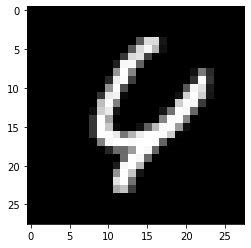

In [128]:
X = np.reshape(X_test[:, 121], (28, 28))
plt.gray()

plt.imshow(X)
print(Y_test[:, 221])